In [197]:
MODELS_FROM_FILE = 1
IMPORTANCES_FROM_FILE = 0

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score, cross_val_predict

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.linear_model import LogisticRegression

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest, mutual_info_classif, f_classif

from sklearn.pipeline import make_pipeline

from sklearn.metrics import confusion_matrix, plot_confusion_matrix, recall_score, precision_score, balanced_accuracy_score, f1_score, roc_auc_score, fbeta_score, make_scorer, roc_curve, precision_recall_curve, accuracy_score
from sklearn.metrics import PrecisionRecallDisplay, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

    
pd.set_option("display.max_columns", None)
pd.set_option('max_colwidth', None)


data_intermediate_dir = "data/intermediate/"
item_lvl_w_imp = pd.read_csv(data_intermediate_dir + "item_lvl_w_impairment.csv")


# Prepare input and ouptut column names

diag_cols = [x for x in item_lvl_w_imp.columns if x.startswith("Diag: ")] # All diagnosis columns

input_cols = [x for x in item_lvl_w_imp.columns if 
                       not x.startswith("Diag: ") 
                       and not x.startswith("WIAT")
                       and not x.startswith("WISC")] # Input columns are all columns except Diagnosis, WIAT, and WISC columns

# Separate test set for all diagnoses

# Shuffle the dataset 
shuffle_df = item_lvl_w_imp.sample(frac=1, random_state=42)

# Define a size for the train set 
train_size = int(0.7 * len(item_lvl_w_imp))

# Split the dataset 
train_set = shuffle_df[:train_size]
test_set = shuffle_df[train_size:] # Don't touch this until the end

# Train_train and Validation set
# Define a size for your train_train set 
train_train_size = int(0.7 * len(train_set))

# Split your dataset 
train_train_set = train_set[:train_train_size]
val_set = train_set[train_train_size:]

In [198]:
def get_base_models_and_param_grids():
    
    # Define base models
    dt = DecisionTreeClassifier()
    rf = RandomForestClassifier()
    svc = svm.SVC()
    lr = LogisticRegression(solver="liblinear")
    
    # Impute missing values
    imputer = SimpleImputer(missing_values=np.nan, strategy='median')
    
    # Standardize data
    scaler = StandardScaler()

    # Make pipelines
    dt_pipe = make_pipeline(imputer, scaler, dt)
    rf_pipe = make_pipeline(imputer, scaler, rf)
    svc_pipe = make_pipeline(imputer, scaler, svc)
    lr_pipe = make_pipeline(imputer, scaler, lr)
    
    # Define parameter grids to search for each pipe
    from scipy.stats import loguniform, uniform
    dt_param_grid = {
        "decisiontreeclassifier__min_samples_split": np.random.randint(2, 20, 30),
        "decisiontreeclassifier__max_depth": np.random.randint(1, 30, 30),
        "decisiontreeclassifier__min_samples_leaf": np.random.randint(1, 20, 30),
        "decisiontreeclassifier__max_leaf_nodes": np.random.randint(2, 50, 30),
        "decisiontreeclassifier__criterion": ['gini', 'entropy'],
        "decisiontreeclassifier__class_weight": ['balanced', None]
    }
    rf_param_grid = {
        'randomforestclassifier__max_depth' : np.random.randint(5, 150, 30),
        'randomforestclassifier__min_samples_split': np.random.randint(2, 50, 30),
        'randomforestclassifier__n_estimators': np.random.randint(50, 400, 10),
        'randomforestclassifier__min_samples_leaf': np.random.randint(1, 20, 30),
        'randomforestclassifier__max_features': ['auto', 'sqrt', 'log2', 0.25, 0.5, 0.75, 1.0],
        'randomforestclassifier__criterion': ['gini', 'entropy'],
        'randomforestclassifier__class_weight':["balanced", "balanced_subsample", None],
        "randomforestclassifier__class_weight": ['balanced', None]
    }
    svc_param_grid = {
        'svc__C': loguniform(1e-03, 1e+02),
        'svc__gamma': loguniform(1e-03, 1e+02),
        'svc__degree': uniform(2, 5),
        'svc__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
        "svc__class_weight": ['balanced', None]
    }
    lr_param_grid = {
        'logisticregression__C': loguniform(1e-5, 100),
        'logisticregression__penalty': ['l1', 'l2']
    }
    
    base_models_and_param_grids = [
        (dt_pipe, dt_param_grid),
        (rf_pipe, rf_param_grid),
        (svc_pipe, svc_param_grid),
        (lr_pipe, lr_param_grid),
    ]
    
    return base_models_and_param_grids

def get_best_classifier(base_model, grid, output_col):
    cv = StratifiedKFold(n_splits=3)
    rs = RandomizedSearchCV(estimator=base_model, param_distributions=grid, cv=cv, scoring="roc_auc", n_iter=100, n_jobs = -1)
    
    rs.fit(train_set[input_cols], train_set[output_col]) # On train_set, not train_train_set because do cross-validation
    
    best_estimator = rs.best_estimator_
    best_score = rs.best_score_
    
    # If chosen model is SVM add a predict_proba parameter (not needed for grid search, and slows it down significantly)
    if 'svc' in best_estimator.named_steps.keys():
        best_estimator.set_params(svc__probability=True)

    return (best_estimator, best_score)

In [199]:
# Calculate probability threshold
beta = 2.5
def calculate_threshold(classifier, output_col, b = beta):
    from numpy import nanargmax
    
    # Fit model on validation set
    classifier.fit(train_train_set[input_cols], train_train_set[output_col])
    
    # Get predicted probabilities values
    y_val_pred_prob = classifier.predict_proba(val_set[input_cols])
    
    # Calculate precision_recall_curve
    precisions, recalls, thresholds = precision_recall_curve(val_set[output_col], y_val_pred_prob[:,1])
    
    # Calculate F-scores
    fscores = ((1+b**2) * precisions * recalls) / ((b**2 * precisions) + recalls)
    
    # Locate the index of the largest F-score
    ix = nanargmax(fscores)
    
    threshold = thresholds[ix]
    
    return threshold

In [200]:
def find_best_classifier_for_diag(diag):
    best_score = 0
    best_classifier = None
    base_models_and_param_grids = get_base_models_and_param_grids()
    for (base_model, grid) in base_models_and_param_grids:
        best_classifier_for_model, best_score_for_model = get_best_classifier(base_model, grid, diag)
        if best_score_for_model > best_score:
            best_classifier = best_classifier_for_model
            best_score = best_score_for_model
    return best_classifier

In [201]:
if MODELS_FROM_FILE == 0:
    best_classifiers = {}
    for diag in diag_cols:
        if item_lvl_w_imp[diag].sum() > 50: # Don't use diagnoses if there are less than 50 positive examples
            best_classifier_for_diag = find_best_classifier_for_diag(diag)
            threshold = calculate_threshold(best_classifier_for_diag, diag, beta)
            best_classifiers[diag] = (best_classifier_for_diag, threshold)
    print(best_classifiers)

In [202]:
# Find best thresholds
def find_best_thresholds(beta=beta):
    best_thresholds = {}
    for diag in diag_cols:
        if item_lvl_w_imp[diag].sum() > 50: # Don't use diagnoses if there are less than 50 positive examples
            best_classifier_for_diag = best_classifiers[diag][0]
            threshold = calculate_threshold(best_classifier_for_diag, diag, beta)
            best_thresholds[diag] = threshold
    print(best_thresholds)
    return best_thresholds

if MODELS_FROM_FILE == 0:
    best_thresholds = find_best_thresholds(beta=beta)

In [203]:
from joblib import dump, load
if MODELS_FROM_FILE == 0:
    # Save best classifiers and thresholds - best parameters, and the classifyer objects themselves
    best_classifiers_df = pd.DataFrame(best_classifiers).T.reset_index()
    best_classifiers_df.columns = ["Diag", "Best Estimator", "Best Threshold"]
    display(best_classifiers_df)
    best_classifiers_df.to_csv("data/output/best-estimators.csv")

    dump(best_classifiers, 'best_classifiers.joblib', compress=1)
    dump(best_thresholds, 'best_thresholds.joblib', compress=1)

In [204]:
if MODELS_FROM_FILE == 1:
    best_classifiers = load('best_classifiers.joblib')
    best_thresholds = load('best_thresholds.joblib')

In [205]:
import math
metric_names = ['TP','TN','FP','FN','Prevalence','Accuracy','Precision','NPV','FDR','FOR','check_Pos','check_Neg','Recall','FPR','FNR','TNR','check_Pos2','check_Neg2','LR+','LR-','DOR','F1','FBeta','MCC','BM','MK']   
def get_matrix_metrics(real_values,pred_values,beta):
    CM = confusion_matrix(real_values,pred_values)
    TN = CM[0][0]+0.01 # +0.01 To avoid division by 0 errors
    FN = CM[1][0]+0.01
    TP = CM[1][1]+0.01
    FP = CM[0][1]+0.01
    Population = TN+FN+TP+FP
    Prevalence = round( (TP+FP) / Population,2)
    Accuracy   = round( (TP+TN) / Population,4)
    Precision  = round( TP / (TP+FP),4 )
    NPV        = round( TN / (TN+FN),4 )
    FDR        = round( FP / (TP+FP),4 )
    FOR        = round( FN / (TN+FN),4 ) 
    check_Pos  = Precision + FDR
    check_Neg  = NPV + FOR
    Recall     = round( TP / (TP+FN),4 )
    FPR        = round( FP / (TN+FP),4 )
    FNR        = round( FN / (TP+FN),4 )
    TNR        = round( TN / (TN+FP),4 ) 
    check_Pos2 = Recall + FNR
    check_Neg2 = FPR + TNR
    LRPos      = round( Recall/FPR,4 ) 
    LRNeg      = round( FNR / TNR ,4 )
    DOR        = round( LRPos/LRNeg)
    F1         = round ( 2 * ((Precision*Recall)/(Precision+Recall)),4)
    FBeta      = round ( (1+beta**2)*((Precision*Recall)/((beta**2 * Precision)+ Recall)) ,4)
    MCC        = round ( ((TP*TN)-(FP*FN))/math.sqrt((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN))  ,4)
    BM         = Recall+TNR-1
    MK         = Precision+NPV-1   
    
    mat_met = [TP,TN,FP,FN,Prevalence,Accuracy,Precision,NPV,FDR,FOR,check_Pos,check_Neg,Recall,FPR,FNR,TNR,check_Pos2,check_Neg2,LRPos,LRNeg,DOR,F1,FBeta,MCC,BM,MK]
    return (mat_met)

In [206]:
def get_metrics(classifier, threshold, output_col, input_cols, validation_or_test = "validation", print_output_flag = 0):
    input_cols = input_cols
    
    if validation_or_test == "test":
        x = test_set[input_cols]
        y = test_set[output_col]
    else: 
        x = val_set[input_cols]
        y = val_set[output_col]
        
    y_pred_prob = classifier.predict_proba(x)
    y_pred = (y_pred_prob[:,1] >= threshold).astype(bool) 
    
    roc_auc = roc_auc_score(y, y_pred_prob[:,1])
    
    metrics = get_matrix_metrics(y, y_pred, beta=3)
    metrics.append(roc_auc)
    
    if print_output_flag:
        print(output_col)
        
        # Display confusion matrix
        cm = confusion_matrix(y, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot()
        plt.show()

        # Display the ROC curve 
        fpr, tpr, thresholds = roc_curve(y, y_pred_prob[:,1])
        plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
        plt.plot(fpr, tpr, marker='.', label='Model')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend()
        plt.show()
        
    return metrics

Diag: Enuresis


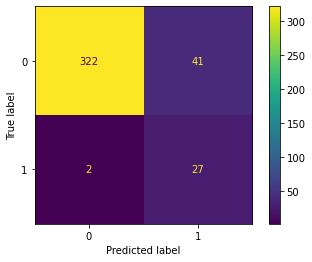

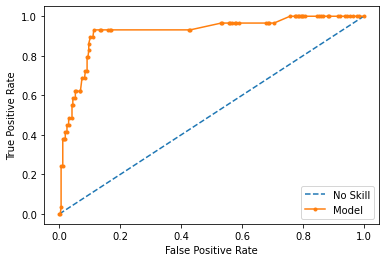

Diag: Autism Spectrum Disorder


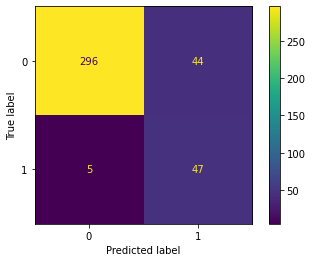

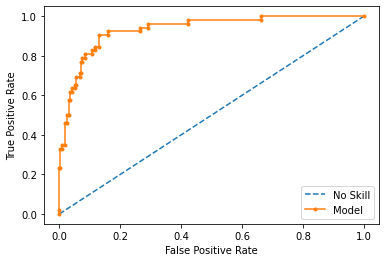

Diag: ADHD-Combined Type


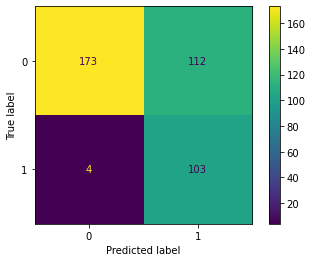

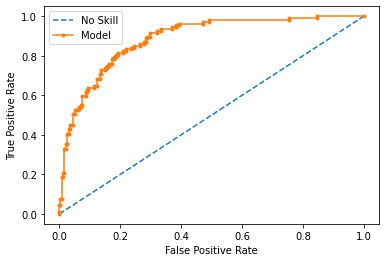

Diag: Specific Learning Disorder with Impairment in Reading


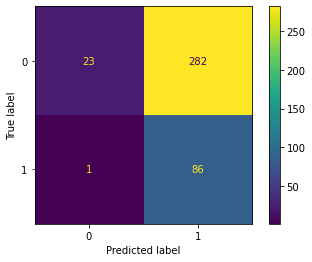

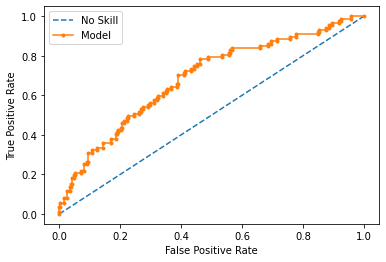

Diag: Generalized Anxiety Disorder


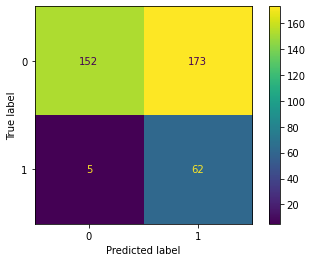

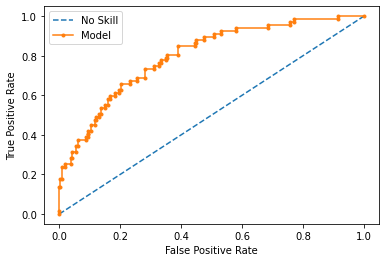

Diag: Specific Learning Disorder with Impairment in Mathematics


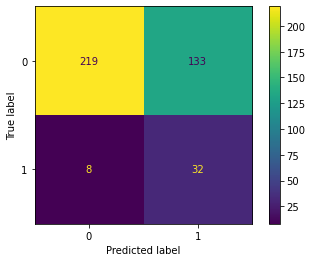

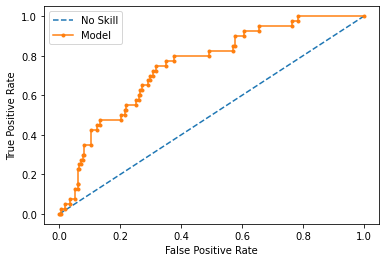

Diag: ADHD-Hyperactive/Impulsive Type


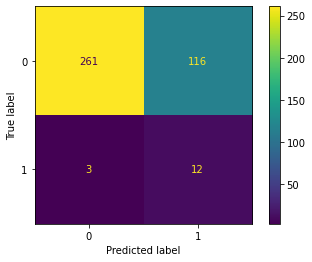

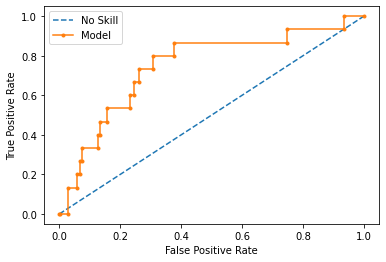

Diag: ADHD-Inattentive Type


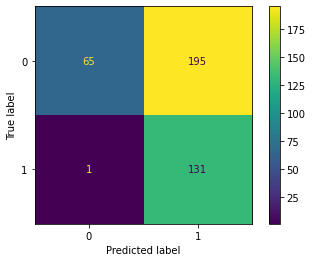

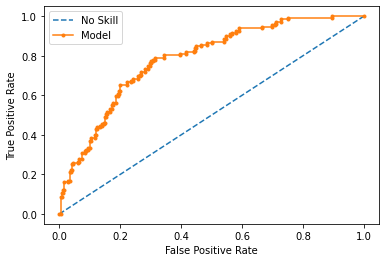

Diag: Oppositional Defiant Disorder


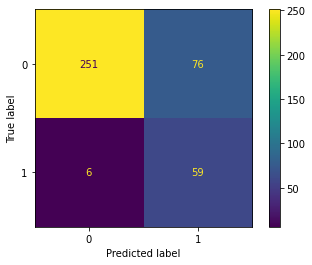

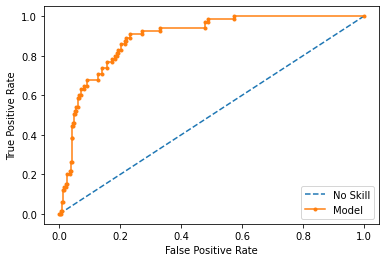

Diag: Specific Phobia


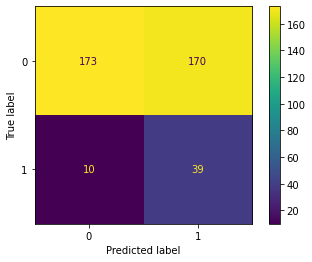

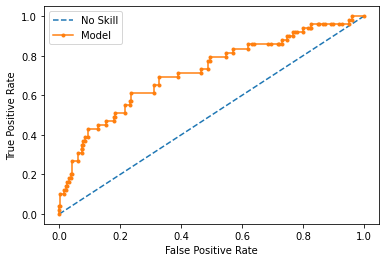

Diag: Specific Learning Disorder with Impairment in Written Expression


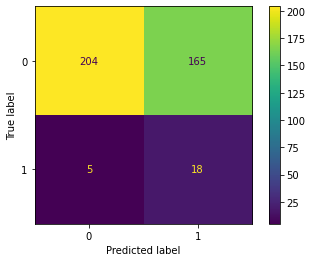

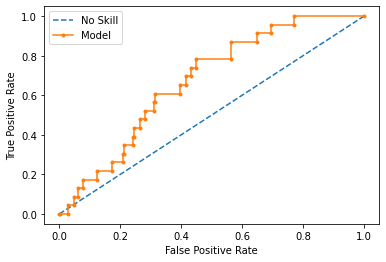

Diag: No Diagnosis Given


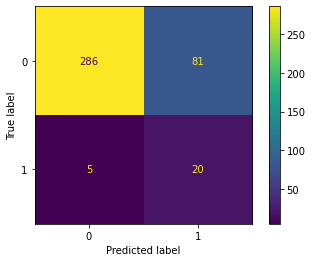

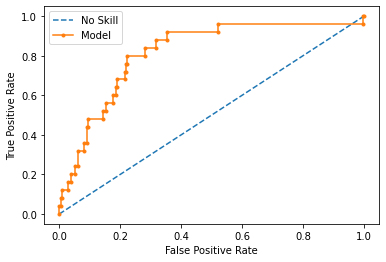

Diag: Obsessive-Compulsive Disorder


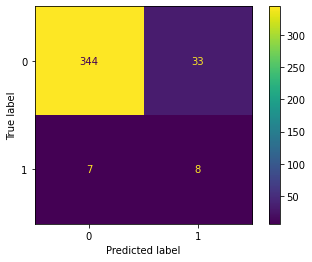

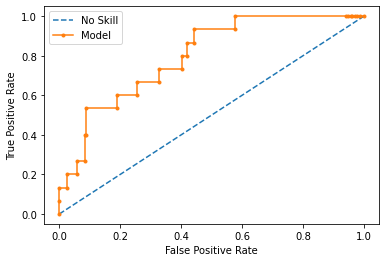

Diag: Speech Sound Disorder


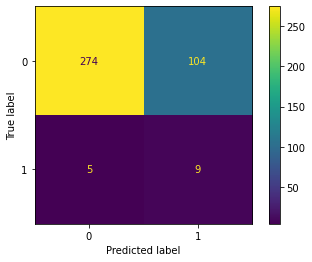

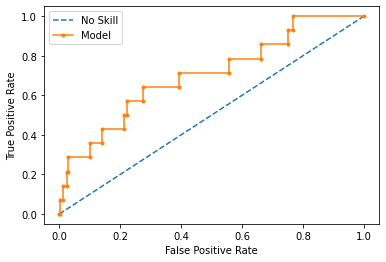

Diag: Other Specified Anxiety Disorder


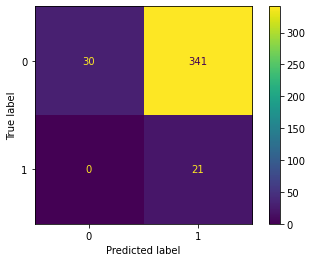

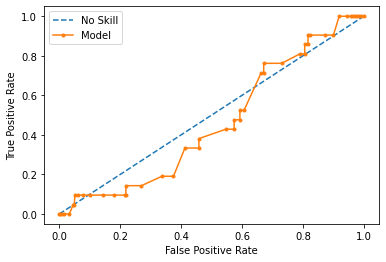

Diag: Persistent (Chronic) Motor or Vocal Tic Disorder


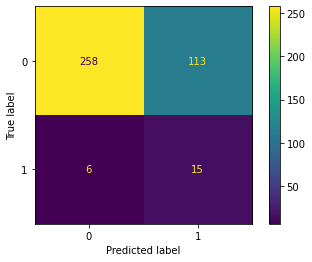

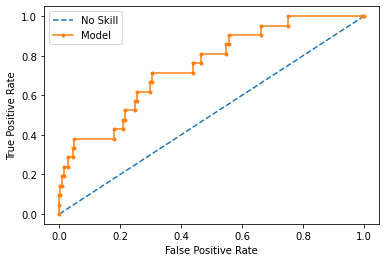

Diag: Social Anxiety (Social Phobia)


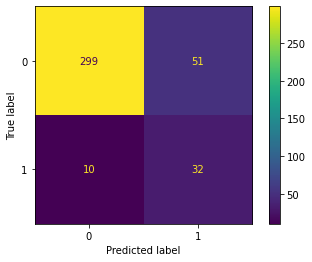

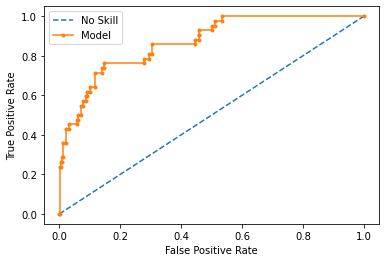

Diag: Major Depressive Disorder


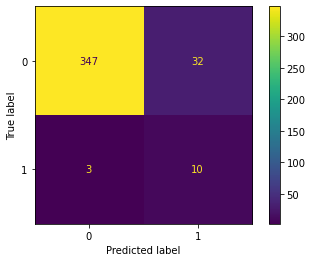

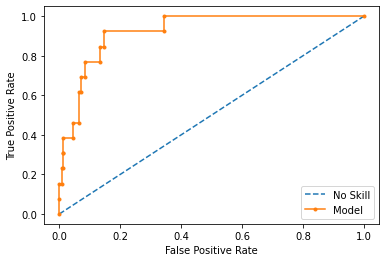

Diag: Other Specified Attention-Deficit/Hyperactivity Disorder


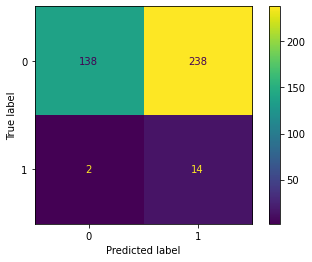

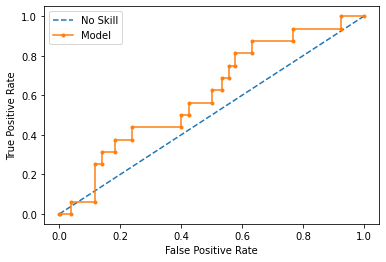

Diag: Separation Anxiety


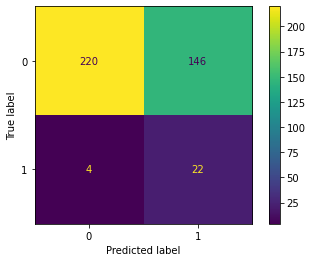

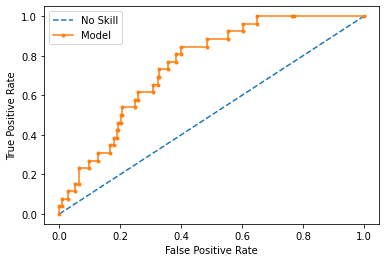

Diag: Language Disorder


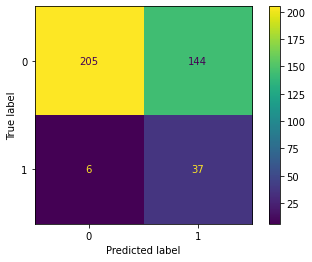

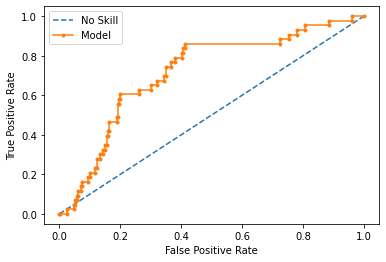

,Diag,TP,TN,FP,FN,Prevalence,Accuracy,Precision,NPV,FDR,FOR,check_Pos,check_Neg,Recall,FPR,FNR,TNR,check_Pos2,check_Neg2,LR+,LR-,DOR,F1,FBeta,MCC,BM,MK,ROC AUC
1,Diag: Autism Spectrum Disorder,47.01,296.01,44.01,5.01,0.23,0.8750,0.5165,0.9834,0.4835,0.0166,1.0,1.0,0.9037,0.1294,0.0963,0.8706,1.0,1.0,6.9838,0.1106,63,0.6573,0.8407,0.6221,0.7743,0.4999,0.934050
17,Diag: Major Depressive Disorder,10.01,347.01,32.01,3.01,0.11,0.9107,0.2382,0.9914,0.7618,0.0086,1.0,1.0,0.7688,0.0845,0.2312,0.9155,1.0,1.0,9.0982,0.2525,36,0.3637,0.6287,0.3964,0.6843,0.2296,0.924295
0,Diag: Enuresis,27.01,322.01,41.01,2.01,0.17,0.8903,0.3971,0.9938,0.6029,0.0062,1.0,1.0,0.9307,0.1130,0.0693,0.8870,1.0,1.0,8.2363,0.0781,105,0.5567,0.8205,0.5654,0.8177,0.3909,0.918685
8,Diag: Oppositional Defiant Disorder,59.01,251.01,76.01,6.01,0.34,0.7908,0.4370,0.9766,0.5630,0.0234,1.0,1.0,0.9076,0.2324,0.0924,0.7676,1.0,1.0,3.9053,0.1204,32,0.5899,0.8194,0.5285,0.6752,0.4136,0.891555
2,Diag: ADHD-Combined Type,103.01,173.01,112.01,4.01,0.55,0.7041,0.4791,0.9773,0.5209,0.0227,1.0,1.0,0.9625,0.3930,0.0375,0.6070,1.0,1.0,2.4491,0.0618,40,0.6398,0.8743,0.5099,0.5695,0.4564,0.887555
16,Diag: Social Anxiety (Social Phobia),32.01,299.01,51.01,10.01,0.21,0.8444,0.3856,0.9676,0.6144,0.0324,1.0,1.0,0.7618,0.1457,0.2382,0.8543,1.0,1.0,5.2286,0.2788,19,0.5120,0.6941,0.4664,0.6161,0.3532,0.868571
11,Diag: No Diagnosis Given,20.01,286.01,81.01,5.01,0.26,0.7806,0.1981,0.9828,0.8019,0.0172,1.0,1.0,0.7998,0.2207,0.2002,0.7793,1.0,1.0,3.6239,0.2569,14,0.3175,0.6135,0.3236,0.5791,0.1809,0.816894
4,Diag: Generalized Anxiety Disorder,62.01,152.01,173.01,5.01,0.60,0.5459,0.2638,0.9681,0.7362,0.0319,1.0,1.0,0.9252,0.5323,0.0748,0.4677,1.0,1.0,1.7381,0.1599,11,0.4105,0.7397,0.3019,0.3929,0.2319,0.799862
12,Diag: Obsessive-Compulsive Disorder,8.01,344.01,33.01,7.01,0.10,0.8979,0.1953,0.9800,0.8047,0.0200,1.0,1.0,0.5333,0.0876,0.4667,0.9124,1.0,1.0,6.0879,0.5115,12,0.2859,0.4546,0.2795,0.4457,0.1753,0.797171
7,Diag: ADHD-Inattentive Type,131.01,65.01,195.01,1.01,0.83,0.5000,0.4018,0.9847,0.5982,0.0153,1.0,1.0,0.9923,0.7500,0.0077,0.2500,1.0,1.0,1.3231,0.0308,43,0.5720,0.8652,0.3061,0.2423,0.3865,0.785286


In [207]:
# Check performance of the final model on validation set for all models

results_val_set = []
for diag in diag_cols:
    if item_lvl_w_imp[diag].sum() > 50:
        classifier = best_classifiers[diag][0]
        threshold = best_thresholds[diag]
        metrics = get_metrics(classifier, threshold, diag, input_cols, 'validation', 1)
        prevalence = item_lvl_w_imp[diag].sum()/len(item_lvl_w_imp)
        results_val_set.append([
            diag, 
            *metrics])
restults_val_set_df = pd.DataFrame(results_val_set, columns=["Diag"]+metric_names+["ROC AUC"])
restults_val_set_df.sort_values(by="ROC AUC", ascending=False)

In [208]:
# Do cross-validation to get more reliable ROC AUC scores (f1 harder to obtain with cross validation - need to change threshold)

auc_cv_mean_val_set = []
auc_cv_std_val_set = []
for diag in diag_cols:
    if item_lvl_w_imp[diag].sum() > 50:
        classifier = best_classifiers[diag][0]
        
        cv = StratifiedKFold(n_splits=5)
        auc = cross_val_score(classifier, train_set[input_cols], train_set[diag], cv=cv, scoring='roc_auc', n_jobs=-1)
        
        auc_cv_mean_val_set.append(auc.mean())
        auc_cv_std_val_set.append(auc.std())
restults_val_set_df["ROC AUC Mean CV"] = pd.Series(auc_cv_mean_val_set)
restults_val_set_df["ROC AUC Std CV"] = pd.Series(auc_cv_std_val_set)
restults_val_set_df

,Diag,TP,TN,FP,FN,Prevalence,Accuracy,Precision,NPV,FDR,FOR,check_Pos,check_Neg,Recall,FPR,FNR,TNR,check_Pos2,check_Neg2,LR+,LR-,DOR,F1,FBeta,MCC,BM,MK,ROC AUC,ROC AUC Mean CV,ROC AUC Std CV
0,Diag: Enuresis,27.01,322.01,41.01,2.01,0.17,0.8903,0.3971,0.9938,0.6029,0.0062,1.0,1.0,0.9307,0.1130,0.0693,0.8870,1.0,1.0,8.2363,0.0781,105,0.5567,0.8205,0.5654,0.8177,0.3909,0.918685,0.907091,0.011059
1,Diag: Autism Spectrum Disorder,47.01,296.01,44.01,5.01,0.23,0.8750,0.5165,0.9834,0.4835,0.0166,1.0,1.0,0.9037,0.1294,0.0963,0.8706,1.0,1.0,6.9838,0.1106,63,0.6573,0.8407,0.6221,0.7743,0.4999,0.934050,0.906224,0.018793
2,Diag: ADHD-Combined Type,103.01,173.01,112.01,4.01,0.55,0.7041,0.4791,0.9773,0.5209,0.0227,1.0,1.0,0.9625,0.3930,0.0375,0.6070,1.0,1.0,2.4491,0.0618,40,0.6398,0.8743,0.5099,0.5695,0.4564,0.887555,0.869380,0.023304
3,Diag: Specific Learning Disorder with Impairment in Reading,86.01,23.01,282.01,1.01,0.94,0.2781,0.2337,0.9580,0.7663,0.0420,1.0,1.0,0.9884,0.9246,0.0116,0.0754,1.0,1.0,1.0690,0.1538,7,0.3780,0.7471,0.1106,0.0638,0.1917,0.685774,0.684650,0.023257
4,Diag: Generalized Anxiety Disorder,62.01,152.01,173.01,5.01,0.60,0.5459,0.2638,0.9681,0.7362,0.0319,1.0,1.0,0.9252,0.5323,0.0748,0.4677,1.0,1.0,1.7381,0.1599,11,0.4105,0.7397,0.3019,0.3929,0.2319,0.799862,0.838532,0.037556
5,Diag: Specific Learning Disorder with Impairment in Mathematics,32.01,219.01,133.01,8.01,0.42,0.6403,0.1940,0.9647,0.8060,0.0353,1.0,1.0,0.7999,0.3778,0.2001,0.6222,1.0,1.0,2.1173,0.3216,7,0.3123,0.6095,0.2588,0.4221,0.1587,0.750071,0.729864,0.049317
6,Diag: ADHD-Hyperactive/Impulsive Type,12.01,261.01,116.01,3.01,0.33,0.6964,0.0938,0.9886,0.9062,0.0114,1.0,1.0,0.7996,0.3077,0.2004,0.6923,1.0,1.0,2.5986,0.2895,9,0.1679,0.4563,0.2013,0.4919,0.0824,0.747657,0.787088,0.042943
7,Diag: ADHD-Inattentive Type,131.01,65.01,195.01,1.01,0.83,0.5000,0.4018,0.9847,0.5982,0.0153,1.0,1.0,0.9923,0.7500,0.0077,0.2500,1.0,1.0,1.3231,0.0308,43,0.5720,0.8652,0.3061,0.2423,0.3865,0.785286,0.769633,0.020283
8,Diag: Oppositional Defiant Disorder,59.01,251.01,76.01,6.01,0.34,0.7908,0.4370,0.9766,0.5630,0.0234,1.0,1.0,0.9076,0.2324,0.0924,0.7676,1.0,1.0,3.9053,0.1204,32,0.5899,0.8194,0.5285,0.6752,0.4136,0.891555,0.881064,0.013397
9,Diag: Specific Phobia,39.01,173.01,170.01,10.01,0.53,0.5408,0.1866,0.9453,0.8134,0.0547,1.0,1.0,0.7958,0.4956,0.2042,0.5044,1.0,1.0,1.6057,0.4048,4,0.3023,0.5999,0.1990,0.3002,0.1319,0.718510,0.714035,0.022757


Diag: Enuresis


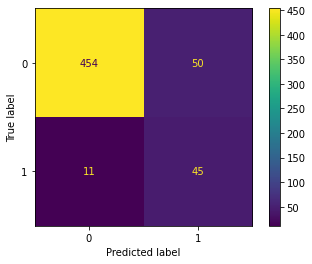

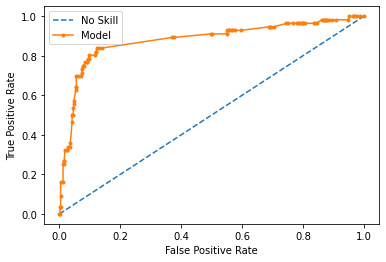

Diag: Autism Spectrum Disorder


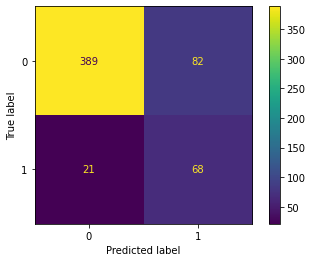

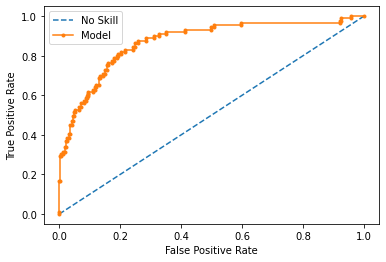

Diag: ADHD-Combined Type


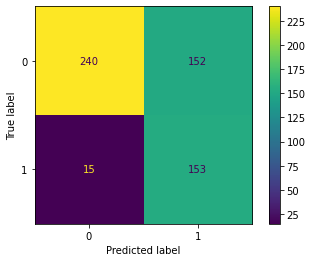

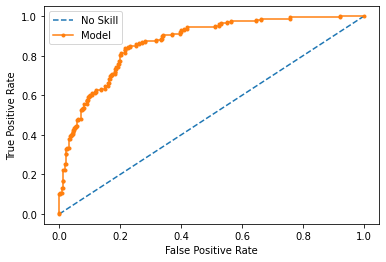

Diag: Specific Learning Disorder with Impairment in Reading


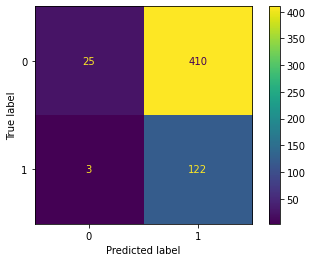

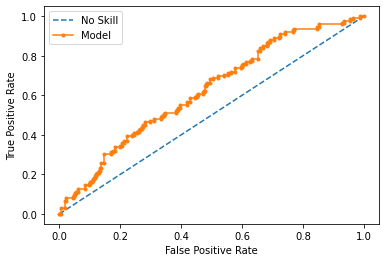

Diag: Generalized Anxiety Disorder


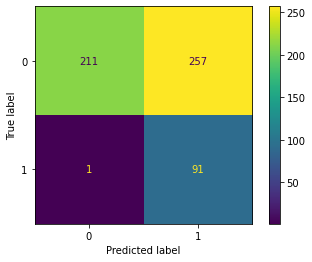

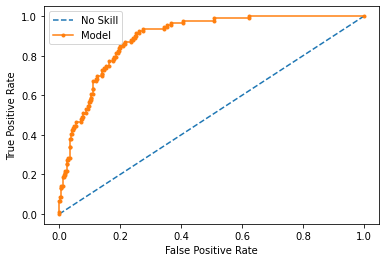

Diag: Specific Learning Disorder with Impairment in Mathematics


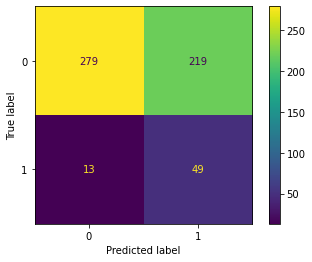

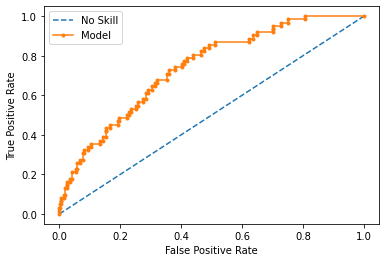

Diag: ADHD-Hyperactive/Impulsive Type


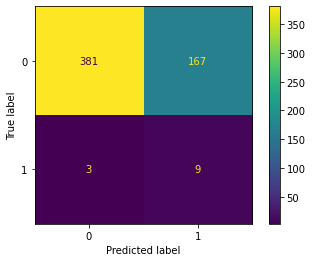

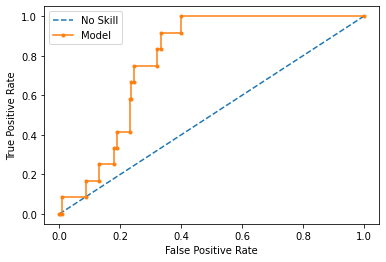

Diag: ADHD-Inattentive Type


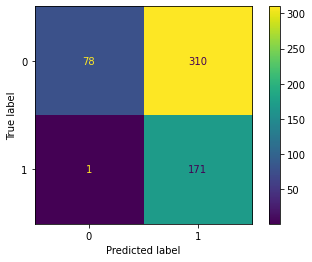

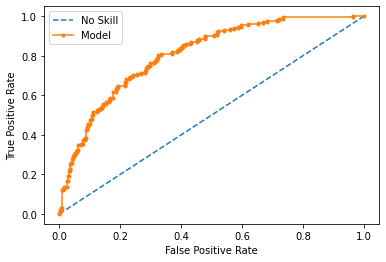

Diag: Oppositional Defiant Disorder


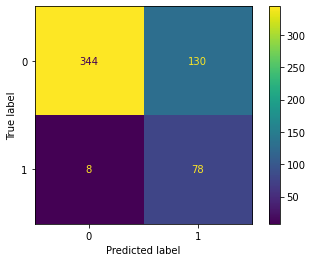

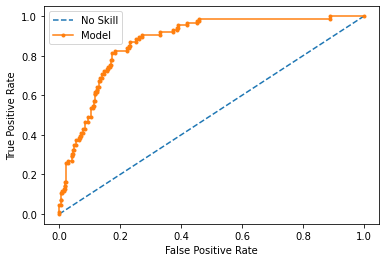

Diag: Specific Phobia


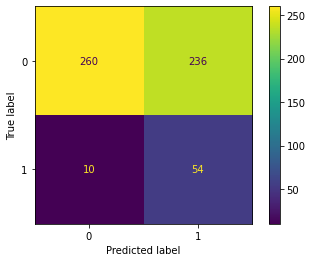

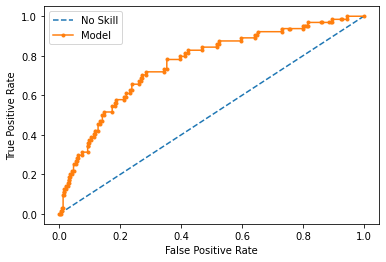

Diag: Specific Learning Disorder with Impairment in Written Expression


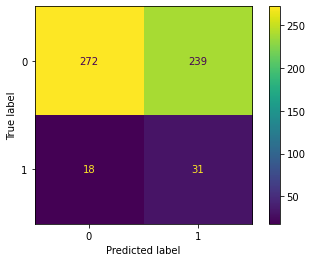

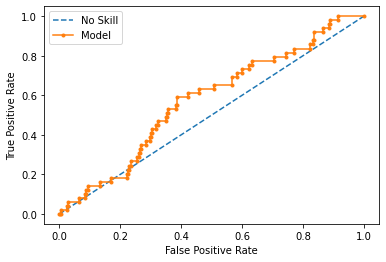

Diag: No Diagnosis Given


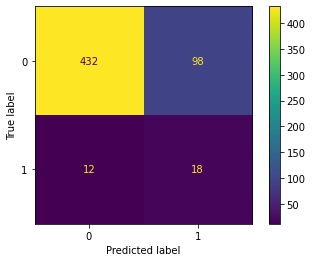

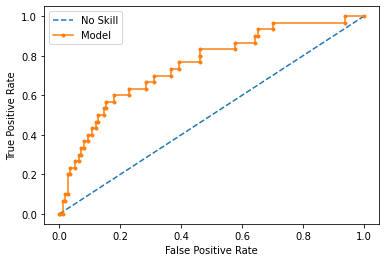

Diag: Obsessive-Compulsive Disorder


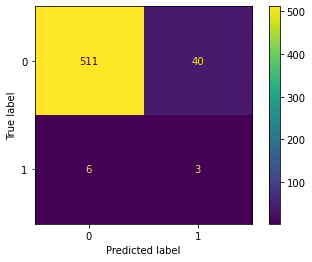

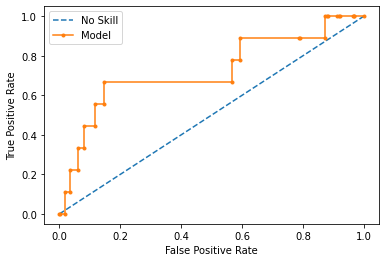

Diag: Speech Sound Disorder


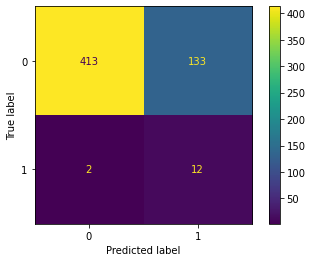

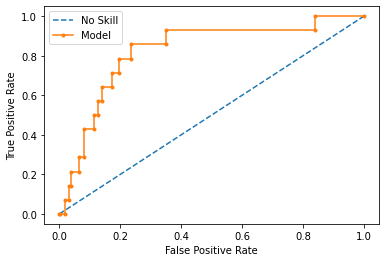

Diag: Other Specified Anxiety Disorder


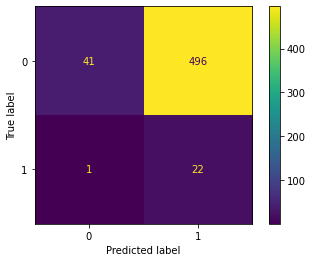

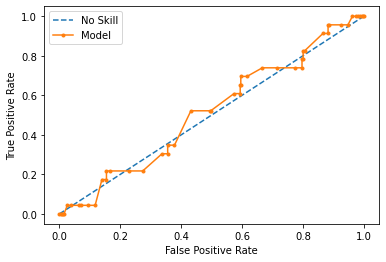

Diag: Persistent (Chronic) Motor or Vocal Tic Disorder


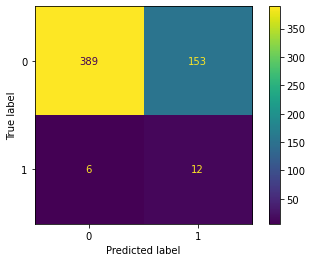

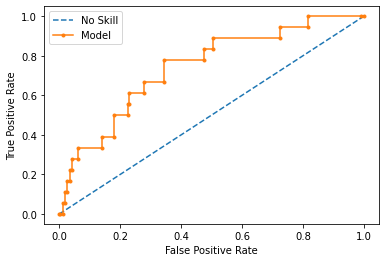

Diag: Social Anxiety (Social Phobia)


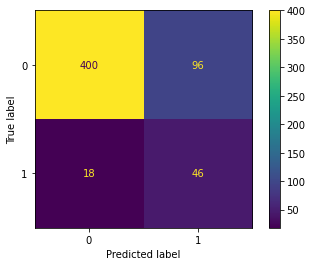

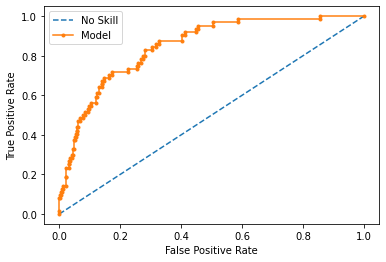

Diag: Major Depressive Disorder


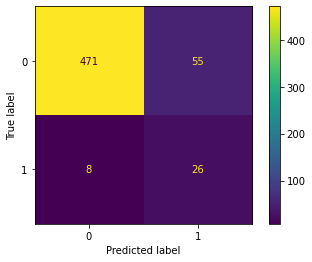

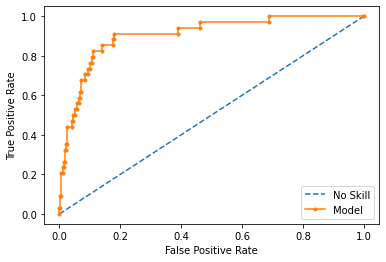

Diag: Other Specified Attention-Deficit/Hyperactivity Disorder


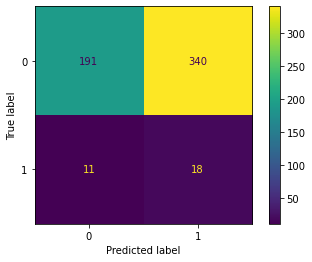

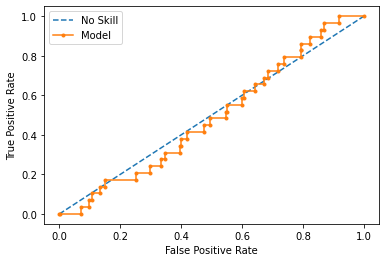

Diag: Separation Anxiety


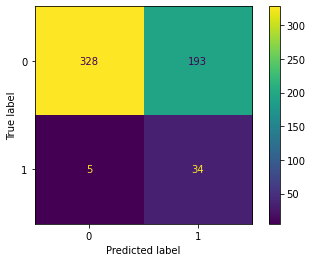

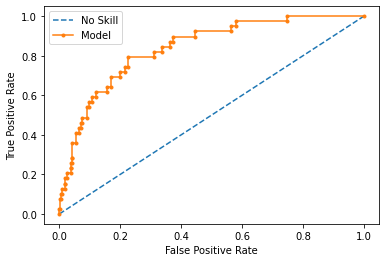

Diag: Language Disorder


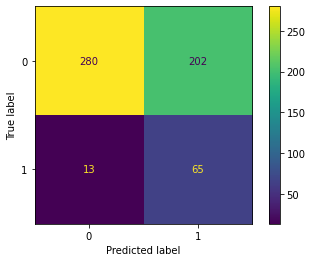

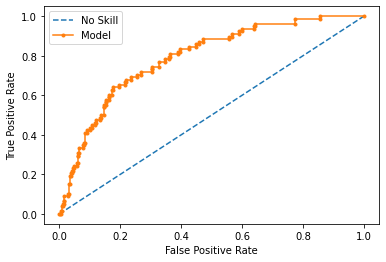

,Diag,TP,TN,FP,FN,Prevalence,Accuracy,Precision,NPV,FDR,FOR,check_Pos,check_Neg,Recall,FPR,FNR,TNR,check_Pos2,check_Neg2,LR+,LR-,DOR,F1,FBeta,MCC,BM,MK,ROC AUC
0,Diag: Enuresis,45.01,454.01,50.01,11.01,0.17,0.8910,0.4737,0.9763,0.5263,0.0237,1.0,1.0,0.8035,0.0992,0.1965,0.9008,1.0,1.0,8.0998,0.2181,37,0.5960,0.7512,0.5630,0.7043,0.4500,0.879429
1,Diag: Autism Spectrum Disorder,68.01,389.01,82.01,21.01,0.27,0.8160,0.4533,0.9488,0.5467,0.0512,1.0,1.0,0.7640,0.1741,0.2360,0.8259,1.0,1.0,4.3883,0.2857,15,0.5690,0.7150,0.4870,0.5899,0.4021,0.872182
2,Diag: ADHD-Combined Type,153.01,240.01,152.01,15.01,0.54,0.7018,0.5016,0.9411,0.4984,0.0589,1.0,1.0,0.9107,0.3878,0.0893,0.6122,1.0,1.0,2.3484,0.1459,16,0.6469,0.8420,0.4812,0.5229,0.4427,0.868926
3,Diag: Specific Learning Disorder with Impairment in Reading,122.01,25.01,410.01,3.01,0.95,0.2625,0.2293,0.8926,0.7707,0.1074,1.0,1.0,0.9759,0.9425,0.0241,0.0575,1.0,1.0,1.0354,0.4191,2,0.3713,0.7362,0.0638,0.0334,0.1219,0.623448
4,Diag: Generalized Anxiety Disorder,91.01,211.01,257.01,1.01,0.62,0.5393,0.2615,0.9952,0.7385,0.0048,1.0,1.0,0.9890,0.5491,0.0110,0.4509,1.0,1.0,1.8011,0.0244,74,0.4136,0.7737,0.3361,0.4399,0.2567,0.892117
5,Diag: Specific Learning Disorder with Impairment in Mathematics,49.01,279.01,219.01,13.01,0.48,0.5857,0.1829,0.9554,0.8171,0.0446,1.0,1.0,0.7902,0.4398,0.2098,0.5602,1.0,1.0,1.7967,0.3745,5,0.2970,0.5932,0.2202,0.3504,0.1383,0.740122
6,Diag: ADHD-Hyperactive/Impulsive Type,9.01,381.01,167.01,3.01,0.31,0.6964,0.0512,0.9922,0.9488,0.0078,1.0,1.0,0.7496,0.3048,0.2504,0.6952,1.0,1.0,2.4593,0.3602,7,0.0959,0.3171,0.1389,0.4448,0.0434,0.783759
7,Diag: ADHD-Inattentive Type,171.01,78.01,310.01,1.01,0.86,0.4446,0.3555,0.9872,0.6445,0.0128,1.0,1.0,0.9941,0.7990,0.0059,0.2010,1.0,1.0,1.2442,0.0294,42,0.5237,0.8427,0.2586,0.1951,0.3427,0.808184
8,Diag: Oppositional Defiant Disorder,78.01,344.01,130.01,8.01,0.37,0.7536,0.3750,0.9772,0.6250,0.0228,1.0,1.0,0.9069,0.2743,0.0931,0.7257,1.0,1.0,3.3062,0.1283,26,0.5306,0.7942,0.4721,0.6326,0.3522,0.873761
9,Diag: Specific Phobia,54.01,260.01,236.01,10.01,0.52,0.5607,0.1862,0.9629,0.8138,0.0371,1.0,1.0,0.8436,0.4758,0.1564,0.5242,1.0,1.0,1.7730,0.2984,6,0.3051,0.6235,0.2342,0.3678,0.1491,0.760758


In [209]:
# Check performance of the final model on test set for all models

results_test_set = []
for diag in diag_cols:
    if item_lvl_w_imp[diag].sum() > 50:
        classifier = best_classifiers[diag][0]
        threshold = best_thresholds[diag]
        metrics = get_metrics(classifier, threshold, diag, input_cols, 'test', 1)
        prevalence = item_lvl_w_imp[diag].sum()/len(item_lvl_w_imp)
        results_test_set.append([
            diag, 
            *metrics])
restults_test_set_df = pd.DataFrame(results_test_set, columns=["Diag"]+metric_names+["ROC AUC"])
restults_test_set_df

### Feature importance

In [210]:
# Only use well performing diagnoses for feature selection: with (Mean CV AUC - Mean CV Std) > 0.65 and F1 Beta > 0.5

diags_with_good_performance = list(restults_val_set_df[((restults_val_set_df["ROC AUC Mean CV"] - restults_val_set_df["ROC AUC Std CV"])>0.65) & (restults_val_set_df["FBeta"] > 0.5)]["Diag"])
display(diags_with_good_performance)
len(diags_with_good_performance)

['Diag: Enuresis',
 'Diag: Autism Spectrum Disorder',
 'Diag: ADHD-Combined Type',
 'Diag: Specific Learning Disorder with Impairment in Reading',
 'Diag: Generalized Anxiety Disorder',
 'Diag: Specific Learning Disorder with Impairment in Mathematics',
 'Diag: ADHD-Inattentive Type',
 'Diag: Oppositional Defiant Disorder',
 'Diag: Specific Phobia',
 'Diag: No Diagnosis Given',
 'Diag: Social Anxiety (Social Phobia)',
 'Diag: Major Depressive Disorder',
 'Diag: Separation Anxiety',
 'Diag: Language Disorder']

14

In [211]:
# From here only learning diagnoses for now, computationnaly expensive to do others
learning_diag_with_good_performance = ['Diag: Specific Learning Disorder with Impairment in Mathematics', 'Diag: Specific Learning Disorder with Impairment in Reading']

In [212]:
if IMPORTANCES_FROM_FILE == 1:
    forward_feature_objects = {}
    backward_feature_objects = {}
    try:
        forward_feature_objects = load('forward_sfs.joblib')
    except Exception as e: print(e)
    try:
        backward_feature_objects = load('backward_sfs.joblib')
    except Exception as e: print(e)

In [213]:
# Find elbow of the curve
def find_elbow(curve):
    from numpy import matlib 
    n_points = len(curve)
    all_coord = np.vstack((range(n_points), curve)).T
    first_point = all_coord[0]
    line_vec = all_coord[-1] - all_coord[0]
    line_vec_norm = line_vec / np.sqrt(np.sum(line_vec**2))
    vec_from_first = all_coord - first_point
    scalar_product = np.sum(vec_from_first * np.matlib.repmat(line_vec_norm, n_points, 1), axis=1)
    vec_from_first_parallel = np.outer(scalar_product, line_vec_norm)
    vec_to_line = vec_from_first - vec_from_first_parallel
    dist_to_line = np.sqrt(np.sum(vec_to_line ** 2, axis=1))
    idx_of_best_point = np.argmax(dist_to_line)
    return idx_of_best_point + 1

def analyze_importances(importances):
    importances_list = []
    for key in importances:
        importances_list.append(importances[key]['avg_score'])
    importances_df = pd.DataFrame(importances_list, index=importances.keys(), columns=["ROC AUC"])
    display(importances_df)

    max_score = max(importances_list)
    n_cols_max_score = importances_df[importances_df["ROC AUC"] == max_score].index[0]
    print("Max score: ", max_score, " at ", n_cols_max_score, " features")
    features_up_to_max_score = importances[n_cols_max_score]["feature_names"]
    display(features_up_to_max_score)

    plt.figure(figsize=(16,8))
    plt.plot(importances_df)
    plt.xticks(np.arange(1,100, 3))
    plt.vlines(np.arange(1,100, 3), ymin=min(importances_list), ymax=max(importances_list), colors='purple', ls=':', lw=1)
    plt.show()
    
    optimal_nb_features = find_elbow(importances_list)
    print("Optimal number of features: ", optimal_nb_features)
    
    features_up_to_optimal = importances[optimal_nb_features]["feature_names"]
    display(features_up_to_optimal)
    
    return (features_up_to_optimal, features_up_to_max_score)

Diag: Specific Learning Disorder with Impairment in Mathematics


,ROC AUC
1,0.655182
2,0.698306
3,0.724769
4,0.737444
5,0.749228
...,...
96,0.838171
97,0.838393
98,0.839030
99,0.839880


Max score:  0.8414315336978596  at  90  features


('SympChck,CSC_01P',
 'SympChck,CSC_02C',
 'SympChck,CSC_03C',
 'SympChck,CSC_09C',
 'SympChck,CSC_17P',
 'SympChck,CSC_22C',
 'SympChck,CSC_24C',
 'SympChck,CSC_34P',
 'SympChck,CSC_40C',
 'SympChck,CSC_46C',
 'SympChck,CSC_48C',
 'SympChck,CSC_55bC',
 'SympChck,CSC_55bP',
 'SympChck,CSC_55eC',
 'SympChck,CSC_55eP',
 'SCQ,SCQ_15',
 'SCQ,SCQ_18',
 'SCQ,SCQ_22',
 'SCQ,SCQ_32',
 'SCQ,SCQ_35',
 'ASSQ,ASSQ_07',
 'ASSQ,ASSQ_10',
 'ASSQ,ASSQ_17',
 'ASSQ,ASSQ_21',
 'ASSQ,ASSQ_24',
 'ASSQ,ASSQ_26',
 'SDQ,SDQ_14',
 'SDQ,SDQ_20',
 'SDQ,SDQ_29_c',
 'SWAN,SWAN_02',
 'SRS,SRS_35',
 'SRS,SRS_42',
 'SRS,SRS_50',
 'SRS,SRS_63',
 'CBCL,CBCL_01',
 'CBCL,CBCL_04',
 'CBCL,CBCL_08',
 'CBCL,CBCL_106',
 'CBCL,CBCL_13',
 'CBCL,CBCL_15',
 'CBCL,CBCL_17',
 'CBCL,CBCL_47',
 'CBCL,CBCL_49',
 'CBCL,CBCL_53',
 'CBCL,CBCL_71',
 'CBCL,CBCL_73',
 'CBCL,CBCL_83',
 'CBCL,CBCL_84',
 'CBCL,CBCL_88',
 'CBCL,CBCL_99',
 'ICU_P,ICU_P_19',
 'ICU_P,ICU_P_20',
 'ICU_P,ICU_P_24',
 'APQ_P,APQ_P_02',
 'APQ_P,APQ_P_10',
 'APQ_P,APQ_

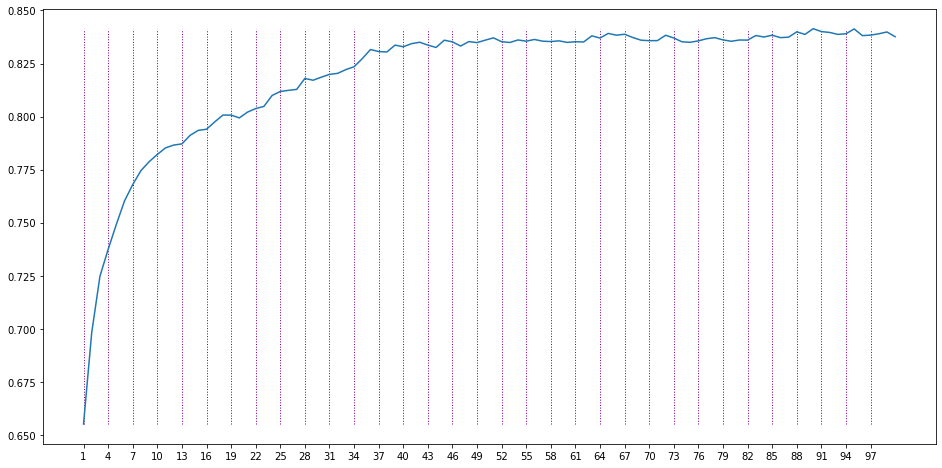

Optimal number of features:  18


('SympChck,CSC_34P',
 'SympChck,CSC_48C',
 'SCQ,SCQ_15',
 'SCQ,SCQ_32',
 'SCQ,SCQ_35',
 'SDQ,SDQ_29_c',
 'SRS,SRS_35',
 'CBCL,CBCL_01',
 'CBCL,CBCL_47',
 'CBCL,CBCL_84',
 'DTS,DTS_04',
 'ESWAN,DMDD_2B',
 'ESWAN,DMDD_3B',
 'WHODAS_P,WHODAS_P_Days02',
 'PSI,PSI_18',
 'PSI,PSI_29',
 'RBS,RBS_25',
 'WHODAS_SR,WHODAS_SR_01')

Diag: Specific Learning Disorder with Impairment in Reading


,ROC AUC
1,0.625159
2,0.658477
3,0.675194
4,0.693117
5,0.706922
...,...
96,0.773403
97,0.772020
98,0.772904
99,0.773424


Max score:  0.7797466774817495  at  66  features


('SympChck,CSC_02C',
 'SympChck,CSC_03P',
 'SympChck,CSC_05C',
 'SympChck,CSC_06C',
 'SympChck,CSC_06P',
 'SympChck,CSC_14C',
 'SympChck,CSC_25C',
 'SympChck,CSC_25P',
 'SympChck,CSC_47C',
 'SympChck,CSC_47P',
 'SympChck,CSC_54P',
 'SympChck,CSC_55bC',
 'SympChck,CSC_55cC',
 'SCQ,SCQ_18',
 'SCQ,SCQ_29',
 'ASSQ,ASSQ_24',
 'SDQ,SDQ_13',
 'SDQ,SDQ_29_a',
 'SRS,SRS_25',
 'SRS,SRS_43',
 'SRS,SRS_51',
 'SRS,SRS_63',
 'SRS,SRS_65',
 'CBCL,CBCL_05',
 'CBCL,CBCL_109',
 'CBCL,CBCL_29',
 'CBCL,CBCL_32',
 'CBCL,CBCL_36',
 'CBCL,CBCL_67',
 'CBCL,CBCL_71',
 'CBCL,CBCL_80',
 'CBCL,CBCL_81',
 'ICU_P,ICU_P_09',
 'ICU_P,ICU_P_13',
 'ICU_P,ICU_P_15',
 'ICU_P,ICU_P_16',
 'ICU_P,ICU_P_18',
 'ICU_P,ICU_P_20',
 'PCIAT,PCIAT_05',
 'DTS,DTS_04',
 'DTS,DTS_05',
 'ESWAN,DMDD_7B',
 'ESWAN,MDD_7',
 'ESWAN,MDD_8A',
 'ESWAN,Panic_A03B',
 'ESWAN,Panic_B10',
 'ESWAN,Panic_B11',
 'ESWAN,SocAnx_05',
 'MFQ_P,MFQ_P_01',
 'MFQ_P,MFQ_P_30',
 'APQ_SR,APQ_SR_04',
 'APQ_SR,APQ_SR_14',
 'APQ_SR,APQ_SR_26A',
 'WHODAS_P,WHODAS_P_

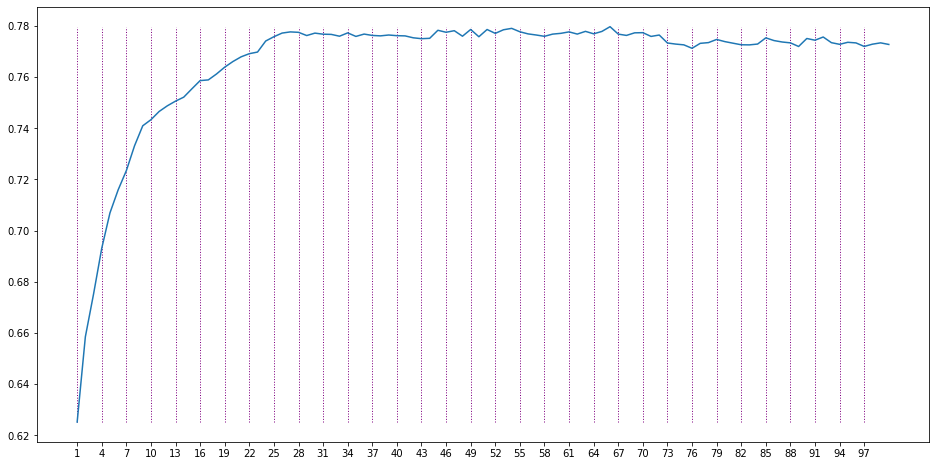

Optimal number of features:  25


('SympChck,CSC_05C',
 'SympChck,CSC_47C',
 'SCQ,SCQ_18',
 'SCQ,SCQ_29',
 'SRS,SRS_25',
 'SRS,SRS_65',
 'CBCL,CBCL_29',
 'CBCL,CBCL_32',
 'CBCL,CBCL_71',
 'CBCL,CBCL_80',
 'ICU_P,ICU_P_09',
 'ICU_P,ICU_P_16',
 'ICU_P,ICU_P_20',
 'DTS,DTS_04',
 'DTS,DTS_05',
 'ESWAN,MDD_7',
 'ESWAN,MDD_8A',
 'APQ_SR,APQ_SR_04',
 'APQ_SR,APQ_SR_14',
 'WHODAS_P,WHODAS_P_02',
 'PSI,PSI_18',
 'RBS,RBS_20',
 'RBS,RBS_40',
 'CIS_SR,CIS_SR_08',
 'APQ_SR,APQ_SR_04A_WAS_MISSING')

In [214]:
from mlxtend.feature_selection import SequentialFeatureSelector

if IMPORTANCES_FROM_FILE == 0:
    forward_feature_subsets = {}
    forward_feature_objects = {}
    for diag in learning_diag_with_good_performance:
        print(diag)
        diag_classifier = best_classifiers[diag][0]

        cv = StratifiedKFold(n_splits=3)
        sfs = SequentialFeatureSelector(diag_classifier, 
              k_features=100,
              forward=True, 
              scoring='roc_auc',
              cv=cv,
              n_jobs=-1)

        sfs = sfs.fit(train_set[input_cols], train_set[diag])

        forward_feature_subsets[diag] = sfs.subsets_
        forward_feature_objects[diag] = sfs
        
        analyze_importances(forward_feature_objects[diag].subsets_)

Diag: Autism Spectrum Disorder


,ROC AUC
1,0.788229
2,0.840931
3,0.865989
4,0.880804
5,0.891419
...,...
96,0.960083
97,0.960127
98,0.960214
99,0.960434


Max score:  0.9605651500540603  at  100  features


('Basic_Demos,Sex',
 'SympChck,CSC_20P',
 'SympChck,CSC_22C',
 'SympChck,CSC_23C',
 'SympChck,CSC_28C',
 'SympChck,CSC_29P',
 'SympChck,CSC_34P',
 'SympChck,CSC_42C',
 'SympChck,CSC_43P',
 'SympChck,CSC_45P',
 'SympChck,CSC_46C',
 'SympChck,CSC_46P',
 'SympChck,CSC_51P',
 'SympChck,CSC_54P',
 'SCQ,SCQ_02',
 'SCQ,SCQ_13',
 'SCQ,SCQ_15',
 'SCQ,SCQ_36',
 'Barratt,financialsupport',
 'ASSQ,ASSQ_03',
 'ARI_P,ARI_P_02',
 'SDQ,SDQ_04',
 'SDQ,SDQ_05',
 'SDQ,SDQ_08',
 'SDQ,SDQ_17',
 'SRS,SRS_10',
 'SRS,SRS_12',
 'SRS,SRS_22',
 'SRS,SRS_28',
 'SRS,SRS_37',
 'SRS,SRS_40',
 'SRS,SRS_42',
 'SRS,SRS_43',
 'SRS,SRS_53',
 'SRS,SRS_55',
 'CBCL,CBCL_107',
 'CBCL,CBCL_108',
 'CBCL,CBCL_110',
 'CBCL,CBCL_14',
 'CBCL,CBCL_18',
 'CBCL,CBCL_20',
 'CBCL,CBCL_28',
 'CBCL,CBCL_29',
 'CBCL,CBCL_32',
 'CBCL,CBCL_50',
 'CBCL,CBCL_54',
 'CBCL,CBCL_61',
 'CBCL,CBCL_77',
 'CBCL,CBCL_82',
 'CBCL,CBCL_84',
 'CBCL,CBCL_91',
 'CBCL,CBCL_98',
 'ICU_P,ICU_P_01',
 'ICU_P,ICU_P_10',
 'ICU_P,ICU_P_16',
 'ICU_P,ICU_P_20',
 'AP

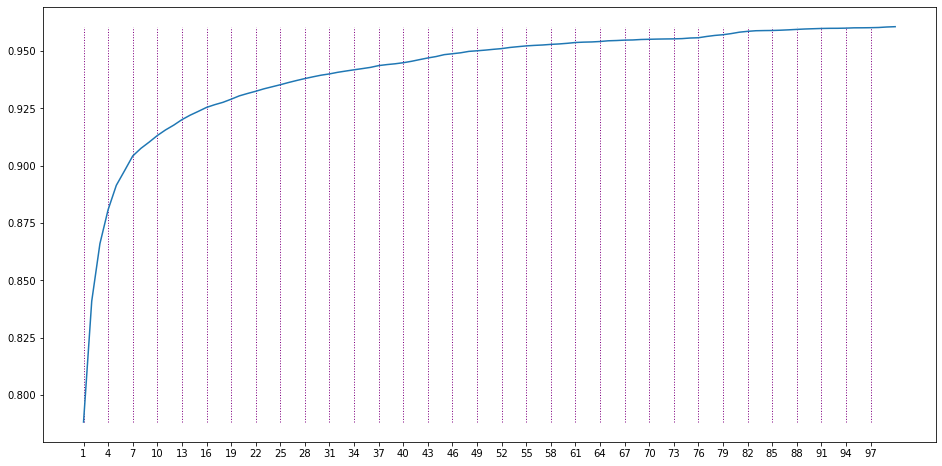

Optimal number of features:  14


('Basic_Demos,Sex',
 'SympChck,CSC_51P',
 'SCQ,SCQ_13',
 'SCQ,SCQ_15',
 'SRS,SRS_22',
 'SRS,SRS_28',
 'SRS,SRS_37',
 'SRS,SRS_42',
 'SRS,SRS_53',
 'CBCL,CBCL_28',
 'CBCL,CBCL_61',
 'ICU_P,ICU_P_16',
 'RBS,RBS_44',
 'WHODAS_SR,WHODAS_SR_04')

Diag: ADHD-Combined Type


,ROC AUC
1,0.792213
2,0.838657
3,0.850999
4,0.863137
5,0.871397
...,...
96,0.890018
97,0.889821
98,0.889552
99,0.889517


Max score:  0.8910280397448652  at  61  features


('SympChck,CSC_02C',
 'SympChck,CSC_07C',
 'SympChck,CSC_16P',
 'SympChck,CSC_24P',
 'SympChck,CSC_36C',
 'SympChck,CSC_36P',
 'SympChck,CSC_39P',
 'SympChck,CSC_42P',
 'SympChck,CSC_55fC',
 'SympChck,CSC_55hP',
 'SCQ,SCQ_09',
 'SCQ,SCQ_23',
 'SCQ,SCQ_40',
 'ASSQ,ASSQ_07',
 'ASSQ,ASSQ_11',
 'ASSQ,ASSQ_27',
 'SDQ,SDQ_02',
 'SDQ,SDQ_22',
 'SDQ,SDQ_29_c',
 'SWAN,SWAN_04',
 'SWAN,SWAN_13',
 'SWAN,SWAN_16',
 'SWAN,SWAN_18',
 'SRS,SRS_55',
 'CBCL,CBCL_33',
 'CBCL,CBCL_56D',
 'CBCL,CBCL_63',
 'CBCL,CBCL_77',
 'CBCL,CBCL_85',
 'ICU_P,ICU_P_12',
 'APQ_P,APQ_P_03',
 'APQ_P,APQ_P_05',
 'APQ_P,APQ_P_10',
 'APQ_P,APQ_P_14',
 'APQ_P,APQ_P_21',
 'APQ_P,APQ_P_34',
 'APQ_P,APQ_P_35',
 'PCIAT,PCIAT_20',
 'DTS,DTS_03',
 'DTS,DTS_08',
 'ESWAN,DMDD_4B',
 'ESWAN,Panic_B02',
 'ESWAN,Panic_B04',
 'MFQ_P,MFQ_P_02',
 'MFQ_P,MFQ_P_15',
 'MFQ_P,MFQ_P_22',
 'MFQ_P,MFQ_P_25',
 'APQ_SR,APQ_SR_16',
 'WHODAS_P,WHODAS_P_09',
 'CIS_P,CIS_P_09',
 'PSI,PSI_22',
 'RBS,RBS_04',
 'RBS,RBS_12',
 'RBS,RBS_14',
 'RBS,RBS_41',
 

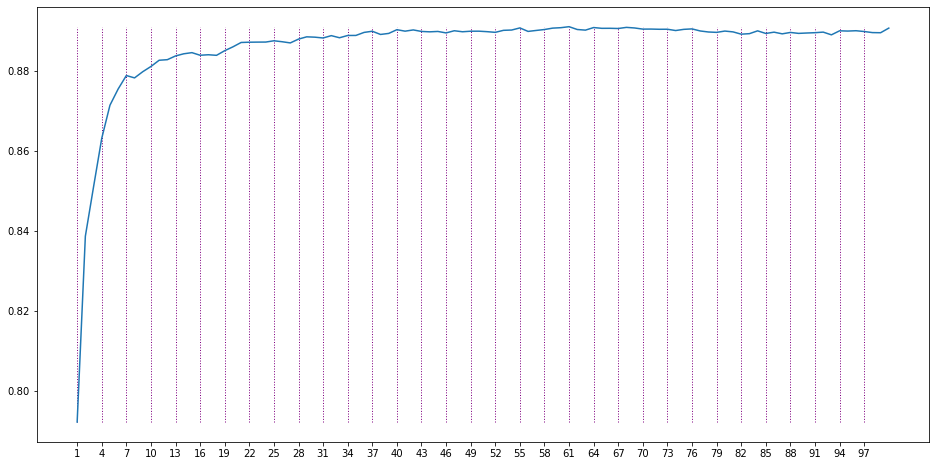

Optimal number of features:  7


('SympChck,CSC_36C',
 'SympChck,CSC_39P',
 'SCQ,SCQ_09',
 'SDQ,SDQ_02',
 'SWAN,SWAN_16',
 'SWAN,SWAN_18',
 'APQ_P,APQ_P_05')

In [218]:
# MANUALLY DO OTHER DIAGS
for diag in ['Diag: Autism Spectrum Disorder', 'Diag: ADHD-Combined Type']:
    print(diag)
    diag_classifier = best_classifiers[diag][0]

    cv = StratifiedKFold(n_splits=3)
    sfs = SequentialFeatureSelector(diag_classifier, 
          k_features=100,
          forward=True, 
          scoring='roc_auc',
          cv=cv,
          n_jobs=-1)

    sfs = sfs.fit(train_set[input_cols], train_set[diag])

    forward_feature_subsets[diag] = sfs.subsets_
    forward_feature_objects[diag] = sfs

    analyze_importances(forward_feature_objects[diag].subsets_)
    dump(forward_feature_objects, 'forward_sfs-adhd-asd.joblib', compress=1) # COMBINE LATER

In [215]:
# Save importances to file
if IMPORTANCES_FROM_FILE == 0:
    dump(forward_feature_objects, 'forward_sfs.joblib', compress=1)

,ROC AUC
1,0.655182
2,0.698306
3,0.724769
4,0.737444
5,0.749228
...,...
96,0.838171
97,0.838393
98,0.839030
99,0.839880


Max score:  0.8414315336978596  at  90  features


('SympChck,CSC_01P',
 'SympChck,CSC_02C',
 'SympChck,CSC_03C',
 'SympChck,CSC_09C',
 'SympChck,CSC_17P',
 'SympChck,CSC_22C',
 'SympChck,CSC_24C',
 'SympChck,CSC_34P',
 'SympChck,CSC_40C',
 'SympChck,CSC_46C',
 'SympChck,CSC_48C',
 'SympChck,CSC_55bC',
 'SympChck,CSC_55bP',
 'SympChck,CSC_55eC',
 'SympChck,CSC_55eP',
 'SCQ,SCQ_15',
 'SCQ,SCQ_18',
 'SCQ,SCQ_22',
 'SCQ,SCQ_32',
 'SCQ,SCQ_35',
 'ASSQ,ASSQ_07',
 'ASSQ,ASSQ_10',
 'ASSQ,ASSQ_17',
 'ASSQ,ASSQ_21',
 'ASSQ,ASSQ_24',
 'ASSQ,ASSQ_26',
 'SDQ,SDQ_14',
 'SDQ,SDQ_20',
 'SDQ,SDQ_29_c',
 'SWAN,SWAN_02',
 'SRS,SRS_35',
 'SRS,SRS_42',
 'SRS,SRS_50',
 'SRS,SRS_63',
 'CBCL,CBCL_01',
 'CBCL,CBCL_04',
 'CBCL,CBCL_08',
 'CBCL,CBCL_106',
 'CBCL,CBCL_13',
 'CBCL,CBCL_15',
 'CBCL,CBCL_17',
 'CBCL,CBCL_47',
 'CBCL,CBCL_49',
 'CBCL,CBCL_53',
 'CBCL,CBCL_71',
 'CBCL,CBCL_73',
 'CBCL,CBCL_83',
 'CBCL,CBCL_84',
 'CBCL,CBCL_88',
 'CBCL,CBCL_99',
 'ICU_P,ICU_P_19',
 'ICU_P,ICU_P_20',
 'ICU_P,ICU_P_24',
 'APQ_P,APQ_P_02',
 'APQ_P,APQ_P_10',
 'APQ_P,APQ_

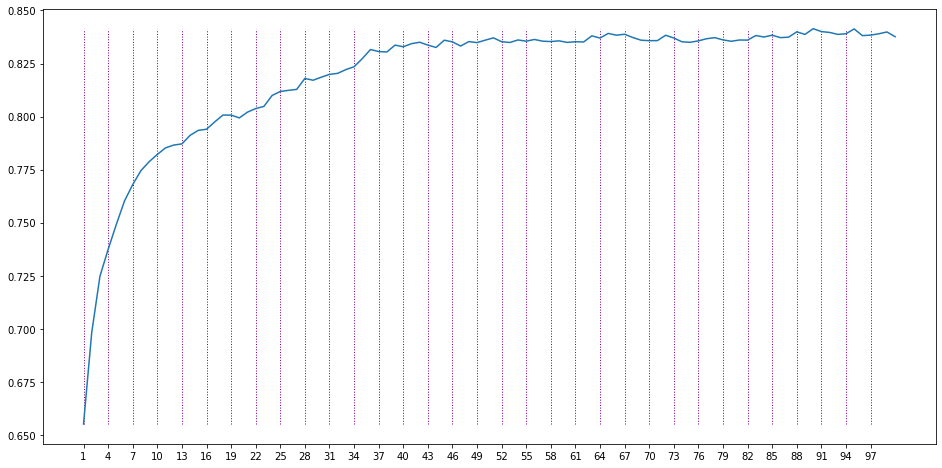

Optimal number of features:  18


('SympChck,CSC_34P',
 'SympChck,CSC_48C',
 'SCQ,SCQ_15',
 'SCQ,SCQ_32',
 'SCQ,SCQ_35',
 'SDQ,SDQ_29_c',
 'SRS,SRS_35',
 'CBCL,CBCL_01',
 'CBCL,CBCL_47',
 'CBCL,CBCL_84',
 'DTS,DTS_04',
 'ESWAN,DMDD_2B',
 'ESWAN,DMDD_3B',
 'WHODAS_P,WHODAS_P_Days02',
 'PSI,PSI_18',
 'PSI,PSI_29',
 'RBS,RBS_25',
 'WHODAS_SR,WHODAS_SR_01')

Score using all features:  0.729864406779661


,ROC AUC
1,0.655182
2,0.698306
3,0.724769
4,0.737444
5,0.749228
...,...
96,0.838171
97,0.838393
98,0.839030
99,0.839880


Max score:  0.8414315336978596  at  90  features


('SympChck,CSC_01P',
 'SympChck,CSC_02C',
 'SympChck,CSC_03C',
 'SympChck,CSC_09C',
 'SympChck,CSC_17P',
 'SympChck,CSC_22C',
 'SympChck,CSC_24C',
 'SympChck,CSC_34P',
 'SympChck,CSC_40C',
 'SympChck,CSC_46C',
 'SympChck,CSC_48C',
 'SympChck,CSC_55bC',
 'SympChck,CSC_55bP',
 'SympChck,CSC_55eC',
 'SympChck,CSC_55eP',
 'SCQ,SCQ_15',
 'SCQ,SCQ_18',
 'SCQ,SCQ_22',
 'SCQ,SCQ_32',
 'SCQ,SCQ_35',
 'ASSQ,ASSQ_07',
 'ASSQ,ASSQ_10',
 'ASSQ,ASSQ_17',
 'ASSQ,ASSQ_21',
 'ASSQ,ASSQ_24',
 'ASSQ,ASSQ_26',
 'SDQ,SDQ_14',
 'SDQ,SDQ_20',
 'SDQ,SDQ_29_c',
 'SWAN,SWAN_02',
 'SRS,SRS_35',
 'SRS,SRS_42',
 'SRS,SRS_50',
 'SRS,SRS_63',
 'CBCL,CBCL_01',
 'CBCL,CBCL_04',
 'CBCL,CBCL_08',
 'CBCL,CBCL_106',
 'CBCL,CBCL_13',
 'CBCL,CBCL_15',
 'CBCL,CBCL_17',
 'CBCL,CBCL_47',
 'CBCL,CBCL_49',
 'CBCL,CBCL_53',
 'CBCL,CBCL_71',
 'CBCL,CBCL_73',
 'CBCL,CBCL_83',
 'CBCL,CBCL_84',
 'CBCL,CBCL_88',
 'CBCL,CBCL_99',
 'ICU_P,ICU_P_19',
 'ICU_P,ICU_P_20',
 'ICU_P,ICU_P_24',
 'APQ_P,APQ_P_02',
 'APQ_P,APQ_P_10',
 'APQ_P,APQ_

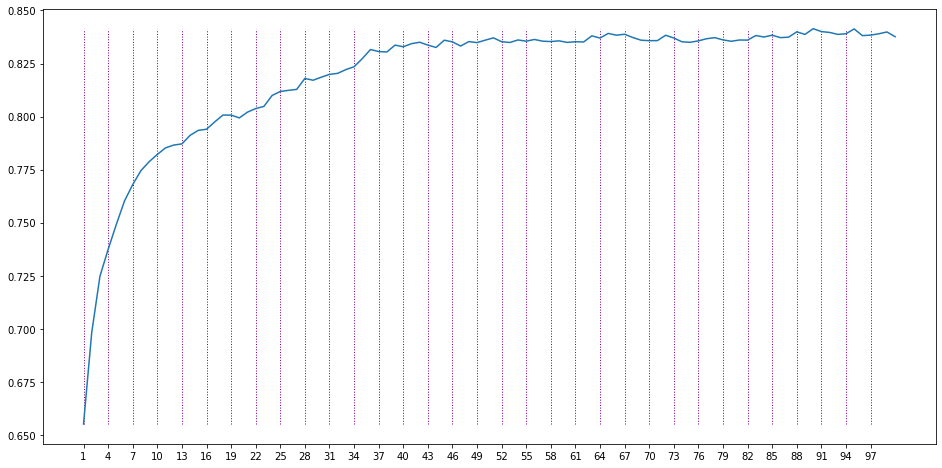

Optimal number of features:  18


('SympChck,CSC_34P',
 'SympChck,CSC_48C',
 'SCQ,SCQ_15',
 'SCQ,SCQ_32',
 'SCQ,SCQ_35',
 'SDQ,SDQ_29_c',
 'SRS,SRS_35',
 'CBCL,CBCL_01',
 'CBCL,CBCL_47',
 'CBCL,CBCL_84',
 'DTS,DTS_04',
 'ESWAN,DMDD_2B',
 'ESWAN,DMDD_3B',
 'WHODAS_P,WHODAS_P_Days02',
 'PSI,PSI_18',
 'PSI,PSI_29',
 'RBS,RBS_25',
 'WHODAS_SR,WHODAS_SR_01')

Performance on test set using optimal number of columns
Performance on test set using number of columns with maximum score
Score using all features:  0.6846502554808829


,ROC AUC
1,0.625159
2,0.658477
3,0.675194
4,0.693117
5,0.706922
...,...
96,0.773403
97,0.772020
98,0.772904
99,0.773424


Max score:  0.7797466774817495  at  66  features


('SympChck,CSC_02C',
 'SympChck,CSC_03P',
 'SympChck,CSC_05C',
 'SympChck,CSC_06C',
 'SympChck,CSC_06P',
 'SympChck,CSC_14C',
 'SympChck,CSC_25C',
 'SympChck,CSC_25P',
 'SympChck,CSC_47C',
 'SympChck,CSC_47P',
 'SympChck,CSC_54P',
 'SympChck,CSC_55bC',
 'SympChck,CSC_55cC',
 'SCQ,SCQ_18',
 'SCQ,SCQ_29',
 'ASSQ,ASSQ_24',
 'SDQ,SDQ_13',
 'SDQ,SDQ_29_a',
 'SRS,SRS_25',
 'SRS,SRS_43',
 'SRS,SRS_51',
 'SRS,SRS_63',
 'SRS,SRS_65',
 'CBCL,CBCL_05',
 'CBCL,CBCL_109',
 'CBCL,CBCL_29',
 'CBCL,CBCL_32',
 'CBCL,CBCL_36',
 'CBCL,CBCL_67',
 'CBCL,CBCL_71',
 'CBCL,CBCL_80',
 'CBCL,CBCL_81',
 'ICU_P,ICU_P_09',
 'ICU_P,ICU_P_13',
 'ICU_P,ICU_P_15',
 'ICU_P,ICU_P_16',
 'ICU_P,ICU_P_18',
 'ICU_P,ICU_P_20',
 'PCIAT,PCIAT_05',
 'DTS,DTS_04',
 'DTS,DTS_05',
 'ESWAN,DMDD_7B',
 'ESWAN,MDD_7',
 'ESWAN,MDD_8A',
 'ESWAN,Panic_A03B',
 'ESWAN,Panic_B10',
 'ESWAN,Panic_B11',
 'ESWAN,SocAnx_05',
 'MFQ_P,MFQ_P_01',
 'MFQ_P,MFQ_P_30',
 'APQ_SR,APQ_SR_04',
 'APQ_SR,APQ_SR_14',
 'APQ_SR,APQ_SR_26A',
 'WHODAS_P,WHODAS_P_

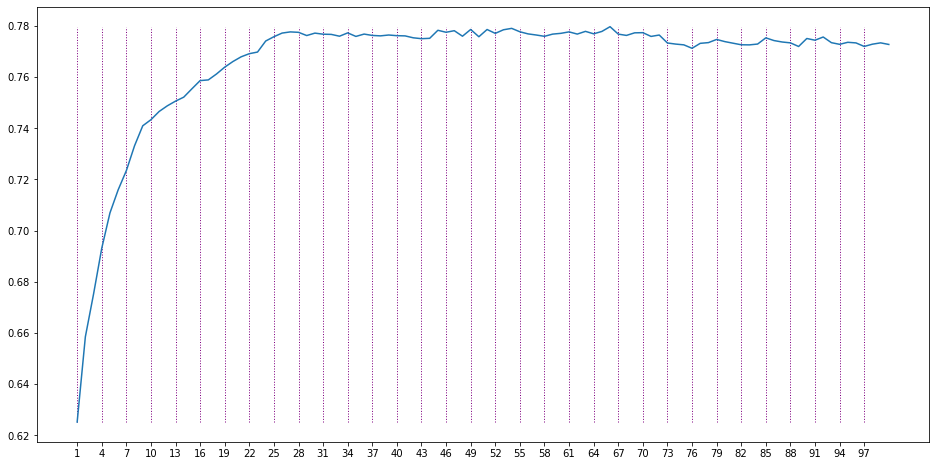

Optimal number of features:  25


('SympChck,CSC_05C',
 'SympChck,CSC_47C',
 'SCQ,SCQ_18',
 'SCQ,SCQ_29',
 'SRS,SRS_25',
 'SRS,SRS_65',
 'CBCL,CBCL_29',
 'CBCL,CBCL_32',
 'CBCL,CBCL_71',
 'CBCL,CBCL_80',
 'ICU_P,ICU_P_09',
 'ICU_P,ICU_P_16',
 'ICU_P,ICU_P_20',
 'DTS,DTS_04',
 'DTS,DTS_05',
 'ESWAN,MDD_7',
 'ESWAN,MDD_8A',
 'APQ_SR,APQ_SR_04',
 'APQ_SR,APQ_SR_14',
 'WHODAS_P,WHODAS_P_02',
 'PSI,PSI_18',
 'RBS,RBS_20',
 'RBS,RBS_40',
 'CIS_SR,CIS_SR_08',
 'APQ_SR,APQ_SR_04A_WAS_MISSING')

Performance on test set using optimal number of columns
Performance on test set using number of columns with maximum score


In [216]:
features_up_to_optimal, features_up_to_max_score = analyze_importances(forward_feature_objects["Diag: Specific Learning Disorder with Impairment in Mathematics"].subsets_)
for diag in learning_diag_with_good_performance:
    print("Score using all features: ", restults_val_set_df[restults_val_set_df["Diag"] == diag]["ROC AUC Mean CV"].iloc[0])
    analyze_importances(forward_feature_objects[diag].subsets_)
    
    # Test both subsets on test set
    classifier = best_classifiers[diag][0]
    threshold = best_thresholds[diag]
    print("Performance on test set using optimal number of columns")
    #metrics = get_metrics(classifier, threshold, diag, features_up_to_optimal, 'test', 1)
    print("Performance on test set using number of columns with maximum score")
    #metrics = get_metrics(classifier, threshold, diag, features_up_to_max_score, 'test', 1)

In [217]:
backward_feature_subsets = {}
backward_feature_objects = {}
if IMPORTANCES_FROM_FILE == 0:
    for diag in learning_diag_with_good_performance:
        print(diag)
        diag_classifier = best_classifiers[diag][0]
        diag_threshold = best_thresholds[diag]

        cv = StratifiedKFold(n_splits=3)
        sfs = SequentialFeatureSelector(diag_classifier, 
              k_features=int(len(input_cols)/3), 
              forward=False, 
              scoring='roc_auc',
              cv=cv,
              n_jobs=-1)

        sfs = sfs.fit(train_set[input_cols], train_set[diag])

        backward_feature_subsets[diag] = sfs.subsets_
        backward_feature_subsets[diag] = sfs

        display(backward_feature_subsets[diag])

Diag: Specific Learning Disorder with Impairment in Mathematics



STOPPING EARLY DUE TO KEYBOARD INTERRUPT...

NameError: name 'backward_feature_subsets' is not defined

In [ ]:
# Save importances to file
if IMPORTANCES_FROM_FILE == 0:
    dump(backward_feature_objects, 'backward_sfs.joblib', compress=1)